# Computational Bionics: Project Exercise 1

Group members:
- Yash Waware (12329556)
- Julian Lork (12243805)
- Florian Frech (12308544)

------------------------

## Task 1: Basic System Model
### 1.1 Description

The following section considers the combination of the sub models of the leg and the **hip drive**.

A PID controller which controls the hip angle according to the provided gait data.
The model only considers the swing phase. The simulation is started at toe off and stops when the leg has ground contact again. In the swing phase there are no acting ground reaction forces and foot moments.

An ideal digital controller (no quantization) with a sampling time of $dt = 0.1$ seconds is used.
$$f = \frac{1}{dt} = 10 Hz$$

Further, an ideal analog sensor for the hip and knee angle is used. The hip and knee angles $q_1$ and $q_2$ are directly used without quantization.

A simple ideal damper in the knee is used to stabilize the system:
$$M_2 = D \cdot \omega_2$$

**PID Controller**

We consider the classic PID (Proprtional-Integrating-Differential) controller

$$u(t) = K_p e(t) + K_I \int e(t) dt + K_D \frac{de(t)}{dt}$$

$$G_R(s) = K_P + \frac{K_I}{s} + K_D s = \frac{K_D s^2 + K_P s + K_I}{s}$$

 - $K_P$: controller gain
 - $K_I$: integrator gain
 - $K_D$: differentiator gain

### 1.2 Simplified Box Model

### 1.3 Simulation

In [1]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize

#### 1.3.1 PID Controller

In [2]:
# Class PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, T):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.T = T
        self.e_km1 = 0
        self.e_km2 = 0
        self.u_km1 = 0
        pass

    def compute_control(self, reference, state):
        e_k = reference - state
        a0 = self.Kp #+ self.Kd / self.T
        a1 = (self.Ki * self.T - 2 * self.Kd / self.T - self.Kp)
        a2 = self.Kd / self.T

        u_k = self.u_km1 + a0 * e_k + a1 * self.e_km1 + a2 * self.e_km2

        self.u_km1 = u_k
        self.e_km2 = self.e_km1
        self.e_km1 = e_k

        return u_k

#### 1.3.2 Parameters

In [3]:
# Parameters Leg Model
m_body = 100 # Body mass [kg]
m1_val = 9.73; m2_val = 5.07; m3_val = 0.44 # Masses [kg]

L1_val = 0.41; l1_val = L1_val / 2 # Lengths thigh [m]
L2_val = 0.415; l2_val = L2_val / 2 # Lengths shank [m]

r_G1 = 0.132; r_G2 = 0.125 # Radius of gyration [m]
J1_val = m1_val * r_G1**2; J2_val = m2_val * r_G2**2 # Moments of inertia [kg m^2]

D_val = 0.1 # Damping coefficients [N m s/rad]

g_val = 9.81 # Gravity [m/s^2]

# Parameters Motor
U_M = 16 # V - motor voltage
U_rated = 48 # V - rated voltage
R_M = 0.151 # Ohm - resistance
L_M = 121e-6 # H - inductance
n_0 = 12916 # rpm - no load speed
w_0 = 2 * np.pi * n_0 / 60 # rad/s
k_n = n_0 * 2 * np.pi / (60 * U_rated) # rad/(Vs) - speed constant
k_M = 0.03 # Nm/A - torque constant
i_G = 60 # gear ratio
eta_G = 0.85 # gear efficiency

#### 1.3.3 Leg Model

In [4]:
# Define the symbolic variables
q1, q2, omega1, omega2 = sp.symbols(r'q_1 q_2 \omega_1 \omega_2')
dot_omega1, dot_omega2 = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
l1, l2, L1, L2 = sp.symbols(r'l_1 l_2 L_1 L_2')
m1, m2, m3 = sp.symbols(r'm_1 m_2 m_3')
J1, J2 = sp.symbols(r'J_1 J_2')
M_drive = sp.symbols(r'M_{drive}')
D = sp.symbols(r'D')
t, g = sp.symbols('t g')

q1 = sp.Function('q_1')(t)
q2 = sp.Function('q_2')(t)

w1 = q1.diff(t)
w2 = q2.diff(t)

dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

# Subustitute dictionary
parameterDict = {m1: m1_val, m2: m2_val, m3: m3_val,
                L1: L1_val, l1: l1_val, L2: L2_val, l2: l2_val,
                J1: J1_val, J2: J2_val,
                g: g_val}

**Euler-Lagrange Formulation**

<div style="width: 50%;">
    <img src="LowerLimb.png" alt="Lower Limb">
</div>

In [5]:
# Position of the center of mass for tigh, shank and foot
r1 = Matrix([l1 * sin(q1),
             -l1 * cos(q1)])

r2 = Matrix([L1 * sin(q1) + l2 * sin(q2),
             -L1 * cos(q1) - l2 * cos(q2)])

r3 = Matrix([L1 * sin(q1) + L2 * sin(q2),
            -L1 * cos(q1) - L2 * cos(q2)])

# Velocity of the center of mass for tigh, shank and foot
v1 = r1.diff(t)
v2 = r2.diff(t)
v3 = r3.diff(t)

# Kinetic energy of the system
T1 = 0.5 * m1 * v1.dot(v1) + 0.5 * J1 * q1.diff(t)**2
T2 = 0.5 * m2 * v2.dot(v2) + 0.5 * J2 * q2.diff(t)**2
T3 = 0.5 * m3 * v3.dot(v3)
T_total = T1 + T2 + T3

# Potential energy of the system
h1 = -l1 * cos(q1)
h2 = -L1 * cos(q1) - l2 * cos(q2)
h3 = -L1 * cos(q1) - L2 * cos(q2)
V1 = m1 * g * h1
V2 = m2 * g * h2
V3 = m3 * g * h3
V_total = V1 + V2 + V3

L = T_total - V_total

**Setting up the system of Equations**

In [6]:
dL_d_dot_q1 = L.diff(q1.diff(t))
dL_d_dot_q2 = L.diff(q2.diff(t))

dL_d_dot_q1_dt = dL_d_dot_q1.diff(t)
dL_d_dot_q2_dt = dL_d_dot_q2.diff(t)

dL_dq1 = L.diff(q1)
dL_dq2 = L.diff(q2)

# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): dot_omega1,
            q2.diff(t, 2): dot_omega2,}

dL_d_dot_q1_dt.subs(subsDict).simplify()
dL_d_dot_q2_dt.subs(subsDict).simplify()

dL_dq1.subs(subsDict).simplify()
dL_dq2.subs(subsDict).simplify()

Q1 = M_drive            # Hip:  External torque from the motor 
Q2 = - D * q2.diff(t)   # Knee: Damping introduced

Q1.subs(subsDict).simplify()
Q2.subs(subsDict).simplify();

# Set up the equations
eq1 = dL_d_dot_q1_dt - dL_dq1 - Q1
eq2 = dL_d_dot_q2_dt - dL_dq2 - Q2

eq1 = eq1.subs(subsDict).simplify()
eq2 = eq2.subs(subsDict).simplify()

# Solve for omega1_dot and omega2_dot
sol = sp.solve([eq1, eq2], (dot_omega1, dot_omega2))

# Extracting and simplifying the solutions
dot_omega1_sol = sol[dot_omega1].simplify()
dot_omega2_sol = sol[dot_omega2].simplify()

In [7]:
# Substitute the values of the parameters
dot_omega1_sol = dot_omega1_sol.subs(parameterDict)
dot_omega2_sol = dot_omega2_sol.subs(parameterDict)

# Lambdify the equations
dot_omega1_func = sp.lambdify((q1, q2, omega1, omega2, M_drive, D), dot_omega1_sol, 'numpy')
dot_omega2_func = sp.lambdify((q1, q2, omega1, omega2, M_drive, D), dot_omega2_sol, 'numpy')

**Read provided Gait Data**

In [8]:
# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')

# Extract gait data
gait_step = np.array(gait_data["gait"][1:].values)

GRFx = np.array(gait_data["GRFx"][1:]) * m_body
GRFz = np.array(gait_data["GRFz"][1:]) * m_body

MX_F = np.array(gait_data["MX_F"][1:]) * m_body
MX_K = np.array(gait_data["MX_K"][1:]) * m_body
MX_H = np.array(gait_data["MX_H"][1:]) * m_body

flex_ext_h_deg = np.array(gait_data["Flex_Ext_H"][1:])
flex_ext_k_deg = np.array(gait_data["Flex_Ext_K"][1:])

In [9]:
# Convert angles to our coordinate system
theta_hip_deg = 90 - flex_ext_h_deg
theta_knee_deg = theta_hip_deg + flex_ext_k_deg - 180

theta_hip_rad = theta_hip_deg * np.pi / 180
theta_knee_rad = theta_knee_deg * np.pi / 180

q1_array = theta_hip_rad
q2_array = theta_knee_rad

**Animation of the Leg Model**

In [10]:
# Verify the gait data by animating the leg
pos_knee_x = np.array([L1_val * np.sin(q1) for q1 in q1_array])
pos_knee_y = np.array([-L1_val * np.cos(q1) for q1 in q1_array])
pos_knee = np.array([pos_knee_x, pos_knee_y])

pos_foot_x = np.array([L1_val * np.sin(q1) + L2_val * np.sin(q2) for q1, q2 in zip(q1_array, q2_array)])
pos_foot_y = np.array([-L1_val * np.cos(q1) - L2_val * np.cos(q2) for q1, q2 in zip(q1_array, q2_array)])
pos_foot = np.array([pos_foot_x, pos_foot_y])

# Set up the figure
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('Leg Gait Animation')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

# Dynamically set axis limits based on the positions
padding = 0.1
min_x = min(np.min(pos_knee[0]), np.min(pos_foot[0])) - padding
max_x = max(np.max(pos_knee[0]), np.max(pos_foot[0])) + padding
min_y = min(np.min(pos_knee[1]), np.min(pos_foot[1])) - padding
max_y = max(np.max(pos_knee[1]), np.max(pos_foot[1])) + padding
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, padding)

# Initialize the lines for animation
line_knee, = ax.plot([], [], 'o-', lw=2, label='Thigh (Hip-Knee)', color='blue')
line_foot, = ax.plot([], [], 'o-', lw=2, label='Shin (Knee-Foot)', color='green')
ax.legend()
ax.grid()

# no show
plt.close()


# Initialization function
def init():  
    line_knee.set_data([], [])
    line_foot.set_data([], [])
    return line_knee, line_foot

# Animation function
def animate(i):
    line_knee.set_data([0, pos_knee[0, i]], [0, pos_knee[1, i]])  # Hip to knee
    line_foot.set_data([pos_knee[0, i], pos_foot[0, i]], [pos_knee[1, i], pos_foot[1, i]])  # Knee to foot
    return line_knee, line_foot

# Create animation
ani = animation.FuncAnimation(
    fig, animate, frames=len(q1_array), init_func=init, blit=True, interval=50
)

# Display animation in Jupyter Notebook
HTML(ani.to_jshtml())

**Analyis the start and end of the swing phase**

In [11]:
np.where(np.abs(MX_F)< 1)

(array([ 0, 14, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
        96, 97, 98, 99], dtype=int64),)

*Consider start of the swing phase at 64 % of the gait cycle*

In [12]:
# Find start of the swing phase - no ground reaction forces and foot moment
threshold = 1
start_swing = np.where(np.abs(MX_F)< threshold)[0][2]

q1_swing_array = q1_array[start_swing:]
q2_swing_array = q2_array[start_swing:]

# deivative of the joint angles
dq1_array = np.gradient(q1_swing_array)
dq2_array = np.gradient(q2_swing_array)

q1_min = np.min(q1_swing_array)
q1_max = np.max(q1_swing_array)

q2_min = np.min(q2_swing_array)
q2_max = np.max(q2_swing_array)

print(f"q1_min: {q1_min:.2f}, q1_max: {q1_max:.2f}")
print(f"q2_min: {q2_min:.2f}, q2_max: {q2_max:.2f}")

q1_min: -0.12, q1_max: 0.40
q2_min: -0.97, q2_max: 0.45


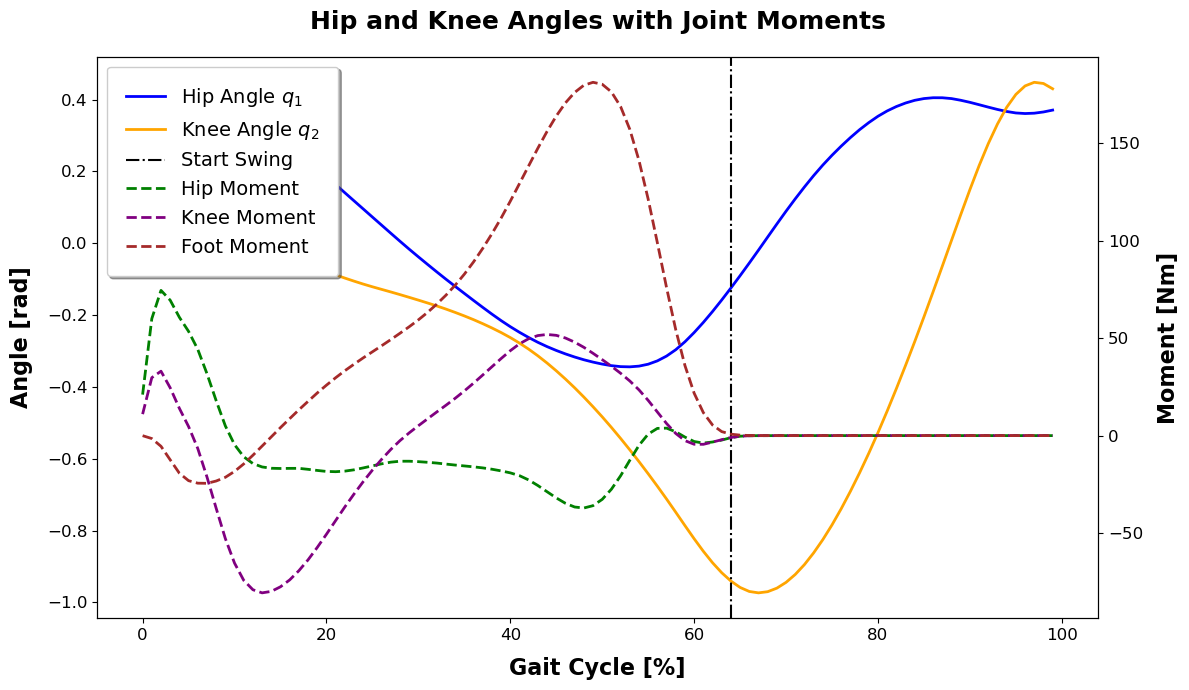

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot hip and knee angles on the primary y-axis
ax1.plot(q1_array, label='Hip Angle $q_1$', color='blue', linewidth=2)
ax1.plot(q2_array, label='Knee Angle $q_2$', color='orange', linewidth=2)
ax1.axvline(start_swing, color='black', linestyle='-.', linewidth=1.5, label='Start Swing')

# Styling the primary y-axis
ax1.set_xlabel('Gait Cycle [%]', fontsize=16, labelpad=10, fontweight='bold')
ax1.set_ylabel('Angle [rad]', fontsize=16, labelpad=10, fontweight='bold')
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12, labelcolor='black')

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot joint moments on the secondary y-axis
ax2.plot(MX_H, label='Hip Moment', color='green', linestyle='--', linewidth=2)
ax2.plot(MX_K, label='Knee Moment', color='purple', linestyle='--', linewidth=2)
ax2.plot(MX_F, label='Foot Moment', color='brown', linestyle='--', linewidth=2)
ax2.set_ylabel('Moment [Nm]', fontsize=16, labelpad=10, fontweight='bold')
ax2.tick_params(axis='y', labelsize=12, labelcolor='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=14, frameon=True, shadow=True, borderpad=1)

# Add a title with enhanced font properties
plt.title('Hip and Knee Angles with Joint Moments', fontsize=18, fontweight='bold', pad=20)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


**Leg Model Equations**

In [14]:
def leg_model(t, y, M_motor, damp_coef):
    omega1, omega2, q1, q2 = y

    domega1 = dot_omega1_func(q1, q2, omega1, omega2, M_motor, damp_coef)
    domega2 = dot_omega2_func(q1, q2, omega1, omega2, M_motor, damp_coef)

    dq1 = omega1
    dq2 = omega2

    return [domega1, domega2, dq1, dq2]

#### 1.3.4 Hip Drive Model

In [15]:
# Dynamic model equations
def motor_model(t, y, u_control, omega_m):
    M = y
    U = U_M * u_control
    n = i_G * omega_m * 30 / np.pi
    I = M / (k_M * i_G * eta_G)
    dI = (U - R_M * I - n / k_n) / L_M
    dM = eta_G * i_G * k_M * dI
    return [dM]

#### 1.3.5 Basic System Model Equation

In [16]:
# Function of the complete system for the solver
def system_equations(t, y, u_control, damp):
    dydt_leg = leg_model(t, y[0:4], y[4], damp)
    dydt_motor = motor_model(t, y[4], u_control, y[0])
    return dydt_leg + dydt_motor

In [17]:
# Initial value
omega1_0 = dq1_array[0] # Initial angular velocity of the thigh
omega2_0 = dq2_array[0] # Initial angular velocity of the shank
q1_0 = q1_swing_array[0] # Initial angle of the thigh
q2_0 = q2_swing_array[0] # Initial angle of the shank
MH_0 = 0 # Initial torque


initial_state = [omega1_0, omega2_0, q1_0, q2_0, MH_0]

dt_control = 0.1
dt_sim = 0.01
t_start = 0
t_end = len(q1_swing_array) * dt_control
t_control = np.arange(t_start, t_end, dt_control)
num_steps = len(t_control)

In [18]:
# Simulation
def simulation(params):
    Kp, Ki, Kd, damp = params
    controller = PIDController(Kp, Ki, Kd, dt_control)

    # Lists for overall results
    t_total = []
    y_total = []
    ref_array = []

    current_state = initial_state

    for t in t_control:
        ref = q1_swing_array[int(t / dt_control)]
        measured = current_state[2]

        u_control = controller.compute_control(ref, measured)
        if u_control > 1: u_control = 1
        if u_control < -1: u_control = -1

        #print(f"Time: {t:.2f}, Reference: {ref:.2f}, Measured: {measured:.2f}, Control: {u_control:.2f}")

        # Define the time span for the current controller interval
        t_span = [t, min(t + controller.T, t_end)]

        # Calculate the time points for t_eval
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) / dt_sim) + 1)

        # Solve the ODE for the current interval, passing the torque as an argument
        sol = solve_ivp(system_equations, t_span, current_state, args=(u_control, damp), t_eval=t_eval, method='BDF', dense_output=True)

        # Update the current state
        current_state = sol.y[:, -1]

        # Store time and state values
        if len(t_total) == 0:
            t_total.extend(sol.t)
            y_total.extend(sol.y.T)
            ref_array.extend([ref] * len(sol.t))
            
        else:
            t_total.extend(sol.t[1:])
            y_total.extend(sol.y.T[1:])
            ref_array.extend([ref] * len(sol.t[1:]))

    return t_total, y_total, ref_array

In [19]:
# Objective function for optimization
def cost_function(params):
    t_sol, y_sol, ref_sol = simulation(params)

    total_error = np.sum(np.abs(np.array(y_sol)[:, 2] - np.array(ref_sol))**2)
    print(f"Kp: {params[0]:.2f} Ki: {params[1]:.2f} Kd: {params[2]:.2f} Error: {total_error:.2f}")

    return total_error

In [20]:
# Initial values for the PID parameters Kp, Ki, Kd
Kp = 25
Ki = 0.0001
Kd = 0.0001
Damp = 0.8

initial_params = [Kp, Ki, Kd, Damp]

# bounds for the PID parameters
bounds = [(0, 500), (0, 500), (0, 500), (0, 1)]

total_error = 0
total_u_control = 0

# Run the optimization
#result = minimize(cost_function, initial_params, bounds=bounds, method='L-BFGS-B')

#Optimized PID parameters:  2.495113452858258 16.290133885300854 0.296132030348925

# Optimized PID parameters
#Kp, Ki, Kd = result.x
print("Optimized PID parameters: ", Kp, Ki, Kd)

Optimized PID parameters:  25 0.0001 0.0001


**Runnning the Simulation**

In [21]:
t_sol, y_sol, ref_sol = simulation([Kp, Ki, Kd, Damp])
q1_sol = np.array(y_sol)[:, 2]
q2_sol = np.array(y_sol)[:, 3]
omega1_sol = np.array(y_sol)[:, 0]
omega2_sol = np.array(y_sol)[:, 1]

**Plotting the Results**

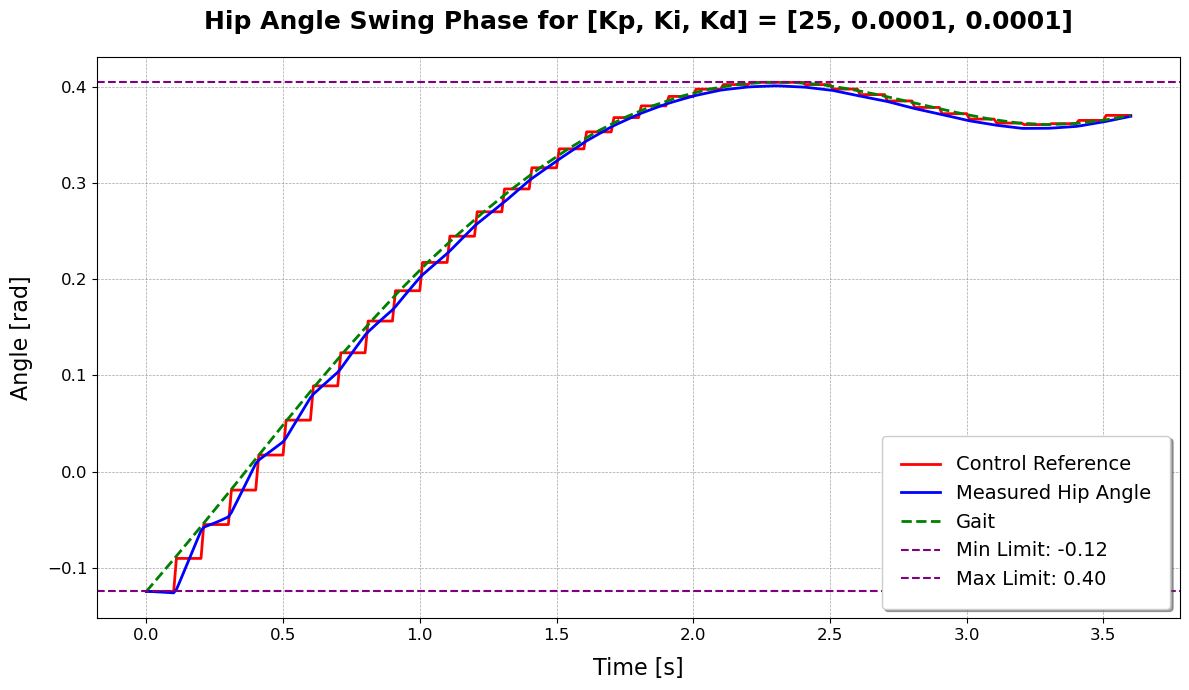

In [43]:
t_vals = np.linspace(0, len(q1_swing_array) * dt_control, len(q1_swing_array))

plt.figure(figsize=(12, 7))

# Plot the data with enhanced styles
plt.plot(t_sol, ref_sol, label='Control Reference', color='red', linewidth=2)
plt.plot(t_sol, q1_sol, label='Measured Hip Angle', color='blue', linewidth=2)
plt.plot(t_vals, q1_swing_array, label='Gait', linestyle='--', color='green', linewidth=2)

# Add horizontal lines with labels for limits
plt.axhline(y=q1_min, color='purple', linestyle='--', linewidth=1.5, label=f'Min Limit: {q1_min:.2f}')
plt.axhline(y=q1_max, color='purple', linestyle='--', linewidth=1.5, label=f'Max Limit: {q1_max:.2f}')


# Axis labels and ticks
plt.xlabel('Time [s]', fontsize=16, labelpad=10)
plt.ylabel('Angle [rad]', fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend with better placement and box styling
plt.legend(loc='lower right', fontsize=14, frameon=True, shadow=True, borderpad=1)

# Title with improved font properties
plt.title(f'Hip Angle Swing Phase for [Kp, Ki, Kd] = [{Kp}, {Ki}, {Kd}]', fontsize=18, fontweight='bold', pad=20)

# Add a grid with custom styling
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### 1.4 Results

### 1.5 Validation Concept of the Basic System Model

----------------------------------------

## Task 2: Real Sensor

### 2.1 Description

The controller output is now quantized.

The hip angle is measured using a potentiometer.

An ADC with an input range of 0 to 3 V is considered.

Measurement noises in the sensor with a standard deviation of $\sigma = 10 \space mV$ are taken into account.

| Variable | Discription | Value
|----------|----------|---------|
| $V_{out}$    | Output Voltage   | ...|
| $V_{in}$  | Input Voltage   | $5V$|
|$V_{micro}$ |Input Voltage microcontroller | $3V$ |
| $R_{pot}$   | Variable resistance of Potentiometer  | ...|
|$\alpha_{max}$| Angular range of Potentiometer |$270°$|
|$R_{fixed}$ |Fixed resistance | $60k\Omega$ |
|$\Delta \theta_{hip}$ |Knee range of motion| $-7.15 °$ to $23.2 ° = 30.35 °$ |
|$M$ |Microcontroller 8 bit ADC| 0 to 255 |

In [23]:
q1_min_deg = np.rad2deg(q1_min)
q1_max_deg = np.rad2deg(q1_max)
bar_q1 = (q1_min_deg + q1_max_deg) / 2
delta_q1_deg = q1_max_deg - q1_min_deg

print(f"Minimum Hip Angle: {q1_min_deg:.2f} degrees")
print(f"Maximum Hip Angle: {q1_max_deg:.2f} degrees")
print(f"Middle Hip Angle:  {bar_q1:.2f} degrees")
print(f"Range of Motion:   {delta_q1_deg:.2f} degrees")

Minimum Hip Angle: -7.15 degrees
Maximum Hip Angle: 23.20 degrees
Middle Hip Angle:  8.03 degrees
Range of Motion:   30.35 degrees


### 2.2 Updated Simplified Box Model

### 2.3 Equations: Potentiometer in a Measuring Bridge

The potentimeter can be used with a measuring bridge, where $Z_i = R_i$ since there is only equivalent current and $R_1$ and $R_2$ correspond to the potentimeter such that

$$R_{pot} = R_1 + R_2$$

![](MeasuringBridge.png)

The amplifier voltage, which is used as input voltag for the µ-controller is given as:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_1+R_2} - \frac{R_4}{R_3+R_4} \right)$$

Substituting $R_{pot} = R_1 + R_2$ yields:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

The resistance of the potentimeter depends linearly on the rotation angle $\theta$. 

$R_1$ and $R_2$ can be rewritten as:

$$R_1 = \frac{\theta}{\Delta\theta} \cdot R_{pot} \quad \quad R_2 = R_{pot} - R_1$$

Inserting these expressions for $R_1$ and $R_2$ yields

$$U_a = U_0 \cdot \left( \frac{R_{pot} - \frac{\theta}{\Delta\theta} \cdot R_{pot} }{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

$$U_a = U_0 \cdot \left( 1 - \frac{\theta}{\Delta\theta} - \frac{R_4}{R_3+R_4} \right)$$

Since the the measuring input voltage range must not exceed $3$ V, the resistors $R_3$ and $R_4$ have to be selected such that the maximum and minimum angles to be measured $\theta_{max}$ and $\theta_{min}$ lie within this voltage range.

We only need to use $\frac{\Delta \theta_{hip}}{\alpha_{max}} = \frac{30.35°}{270°} = 11.25 \space \%$ of the available range of the potentiometer.

Hence we can shift the measuring range to the middle of the potentiometer range:

$$\alpha_{pot} = \theta_{hip} - \frac{\theta_{min} + \theta_{max}}{2} + \frac{\alpha_{max}}{2}$$

Thus $\bar \theta_{hip} = \frac{\theta_{min} + \theta_{max}}{2} = 8.025°$ corresponds to the middle of the measuring range $\frac{\alpha_{max}}{2} = 135 °$.

To obtain an output voltage of $\frac{U_{ADC}}{2} = 1.5 \space V$ for $\bar \theta_{hip} = 8.025 °$, we have to choose $R_4$ and $R_3$ as:

$$\frac{R_4}{R_3+R_4} = 0.2 $$

We set $R_4 = 20 \space k\Omega$ and obtain for $R_3$:

$$R_3 = \frac{R_4 - 0.2 \cdot R_4}{0.2} = 4 \cdot R_4 = 80 \space k \Omega$$



Thus, we prevent voltages close to the limits of the measuring range as the input voltage for the PID controller. Voltages close to zero could lead to the controller not being able to control the system properly.

Hence, we obtain for $U_a$:

$$U_a = U_0 \cdot \left( 1 - 0.2 - \frac{\alpha_{pot}}{\alpha_{max}} \right) = U_0 \cdot \left(0.8 - \frac{\alpha_{pot}}{\alpha_{max}} \right)$$

### 2.4 Simulation with Real Sensor

In [24]:
# Sensor
U_0_pot = 5 # V
U_ADC = 3 # V
bits = 10
alpha_max = 270 # degrees
R3 = 80e3 # Ohm
R4 = 20e3 # Ohm

def sensor(q, noise_std, n_bits):
    q = np.rad2deg(q)
    theta_hip = q - bar_q1 + alpha_max / 2

    U_a = U_0_pot * (1 - R4 / (R3 + R4) - theta_hip / alpha_max)

    # Add Gaussian noise
    mean = 0
    U_a_noisy = np.random.normal(mean, noise_std, 1)

    # Overlay signal with noise
    U_a_noisy += U_a

    U_a_noisy[U_a_noisy < 0] = 0
    U_a_noisy[U_a_noisy > U_0_pot] = U_0_pot

    # Numver of quantization levels
    Q = 2**n_bits - 1

    # Quantize the signal
    delta = U_ADC / Q
    U_a_quantized = delta * np.round(U_a_noisy / delta)
    
    return U_a_quantized

**Sensor Validation**

In [37]:
hip_angle_range = np.arange(q1_min_deg, q1_max_deg, 0.1)
U_adc_ref = []
U_adc_ref_noisy = []
bits = 8
for q in hip_angle_range:
    U_adc_ref.append(sensor(np.deg2rad(q), 0, bits))
    U_adc_ref_noisy.append(sensor(np.deg2rad(q), 0.05, bits))

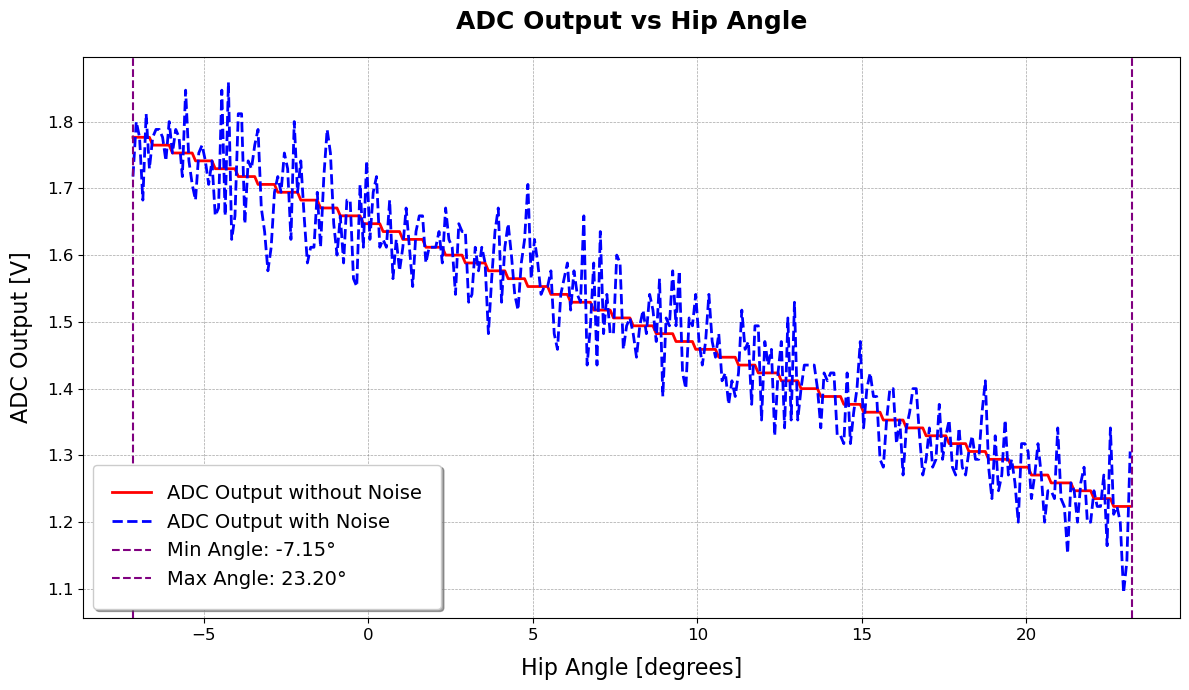

In [44]:
plt.figure(figsize=(12, 7))

# Plot the data with enhanced styles
plt.plot(hip_angle_range, U_adc_ref, label='ADC Output without Noise', color='red', linewidth=2)
plt.plot(hip_angle_range, U_adc_ref_noisy, label='ADC Output with Noise', color='blue', linewidth=2, linestyle='--')

# Add vertical lines for minimum and maximum angles with labels
plt.axvline(x=q1_min_deg, color='purple', linestyle='--', linewidth=1.5, label=f'Min Angle: {q1_min_deg:.2f}°')
plt.axvline(x=q1_max_deg, color='purple', linestyle='--', linewidth=1.5, label=f'Max Angle: {q1_max_deg:.2f}°')


# Axis labels and ticks
plt.xlabel('Hip Angle [degrees]', fontsize=16, labelpad=10)
plt.ylabel('ADC Output [V]', fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend with improved placement and styling
plt.legend(loc='lower left', fontsize=14, frameon=True, shadow=True, borderpad=1)

# Title with enhanced font properties
plt.title('ADC Output vs Hip Angle', fontsize=18, fontweight='bold', pad=20)

# Add a grid with custom styling
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


**Simulation with sensor**

In [26]:
# Simulation
def simulation_sensor(params):
    Kp, Ki, Kd, damp, n_bits, noise_std = params
    controller = PIDController(Kp, Ki, Kd, dt_control)

    # Lists for overall results
    t_total = []
    y_total = []
    ref_array = []

    current_state = initial_state

    for t in t_control:
        ref = sensor(q1_swing_array[int(t / dt_control)], noise_std, n_bits)[0]
        measured = sensor(current_state[2], noise_std, n_bits)[0]

        u_control = controller.compute_control(ref, measured)
        if u_control > 1: u_control = 1
        if u_control < -1: u_control = -1

        #print(f"Time: {t:.2f}, Reference: {ref:.2f}, Measured: {measured:.2f}, Control: {u_control:.2f}")

        # Define the time span for the current controller interval
        t_span = [t, min(t + controller.T, t_end)]

        # Calculate the time points for t_eval
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) / dt_sim) + 1)

        # Solve the ODE for the current interval, passing the torque as an argument
        sol = solve_ivp(system_equations, t_span, current_state, args=(u_control, damp), t_eval=t_eval, method='BDF', dense_output=True)

        # Update the current state
        current_state = sol.y[:, -1]

        # Store time and state values
        if len(t_total) == 0:
            t_total.extend(sol.t)
            y_total.extend(sol.y.T)
            ref_array.extend([ref] * len(sol.t))
            
        else:
            t_total.extend(sol.t[1:])
            y_total.extend(sol.y.T[1:])
            ref_array.extend([ref] * len(sol.t[1:]))

    return t_total, y_total, ref_array

**Simulation using 8 bit ADC**

In [57]:
noise_std = 0.1
n_bits = [8, 10]
results = {n_bits[0]: [], n_bits[1]: []}

for bits in n_bits:
    params = [Kp, Ki, Kd, Damp, bits, noise_std]
    t_sol_sensor, y_sol_sensor, ref_sol_sensor = simulation_sensor(params)
    q1_sol_sensor = np.array(y_sol_sensor)[:, 2]
    q2_sol_sensor = np.array(y_sol_sensor)[:, 3]
    omega1_sol_sensor = np.array(y_sol_sensor)[:, 0]
    omega2_sol_sensor = np.array(y_sol_sensor)[:, 1]
    results[bits] = [t_sol_sensor, q1_sol_sensor, q2_sol_sensor, omega1_sol_sensor, omega2_sol_sensor, ref_sol_sensor]

# params = [Kp, Ki, Kd, Damp, n_bits, noise_std]

# t_sol_sensor, y_sol_sensor, ref_sol_sensor = simulation_sensor(params)
# q1_sol_sensor = np.array(y_sol)[:, 2]
# q2_sol_sensor = np.array(y_sol)[:, 3]
# omega1_sol_sensor = np.array(y_sol)[:, 0]
# omega2_sol_sensor = np.array(y_sol)[:, 1]

{8: [[0.0,
   0.01,
   0.02,
   0.03,
   0.04,
   0.05,
   0.06,
   0.07,
   0.08,
   0.09,
   0.1,
   0.11,
   0.12000000000000001,
   0.13,
   0.14,
   0.15000000000000002,
   0.16,
   0.17,
   0.18,
   0.19,
   0.2,
   0.21000000000000002,
   0.22000000000000003,
   0.23000000000000004,
   0.24000000000000002,
   0.25,
   0.26,
   0.27,
   0.28,
   0.29000000000000004,
   0.30000000000000004,
   0.31111111111111117,
   0.32222222222222224,
   0.33333333333333337,
   0.3444444444444445,
   0.35555555555555557,
   0.3666666666666667,
   0.37777777777777777,
   0.3888888888888889,
   0.4,
   0.41111111111111115,
   0.4222222222222222,
   0.43333333333333335,
   0.4444444444444445,
   0.45555555555555555,
   0.4666666666666667,
   0.47777777777777775,
   0.4888888888888889,
   0.5,
   0.5111111111111111,
   0.5222222222222223,
   0.5333333333333333,
   0.5444444444444444,
   0.5555555555555556,
   0.5666666666666667,
   0.5777777777777777,
   0.5888888888888889,
   0.6,
   0.61111111111

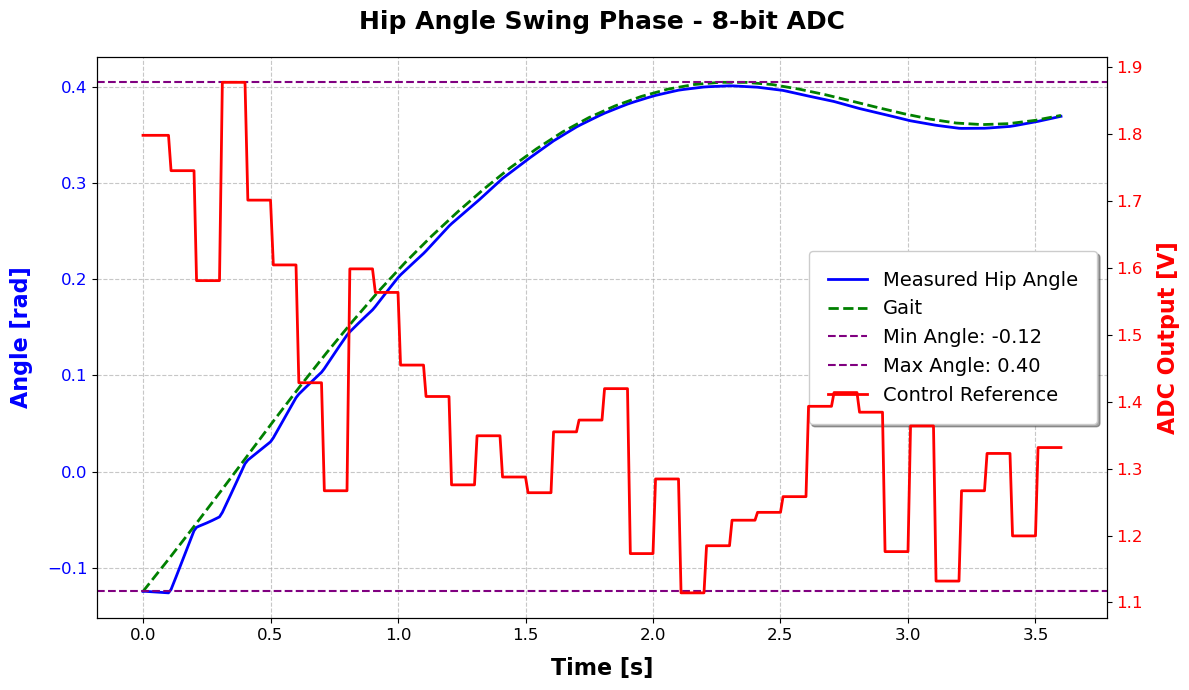

In [55]:
# Plot the results - angles
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot the measured hip angle and gait on the primary y-axis
ax1.plot(t_sol_sensor, q1_sol_sensor, label='Measured Hip Angle', color='blue', linewidth=2)
ax1.plot(t_vals, q1_swing_array, label='Gait', linestyle='--', color='green', linewidth=2)
ax1.axhline(y=q1_min, color='purple', linestyle='--', linewidth=1.5, label=f'Min Angle: {q1_min:.2f}')
ax1.axhline(y=q1_max, color='purple', linestyle='--', linewidth=1.5, label=f'Max Angle: {q1_max:.2f}')

# Styling the primary y-axis
ax1.set_xlabel('Time [s]', fontsize=16, labelpad=10, fontweight='bold')
ax1.set_ylabel('Angle [rad]', fontsize=16, labelpad=10, fontweight='bold', color='blue')
ax1.tick_params(axis='y', labelsize=12, labelcolor='blue')
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for the control reference (ADC output)
ax2 = ax1.twinx()
ax2.plot(t_sol_sensor, ref_sol_sensor, label='Control Reference', color='red', linewidth=2)
ax2.set_ylabel('ADC Output [V]', fontsize=16, labelpad=10, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelsize=12, labelcolor='red')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='right', fontsize=14, frameon=True, shadow=True, borderpad=1)

# Title with enhanced font properties
plt.title('Hip Angle Swing Phase - 8-bit ADC', fontsize=18, fontweight='bold', pad=20)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

**Simulation using 10 bit ADC**

In [29]:
n_bits = 10

params = [Kp, Ki, Kd, Damp, n_bits, noise_std]

t_sol_sensor, y_sol_sensor, ref_sol_sensor = simulation_sensor(params)
q1_sol_sensor = np.array(y_sol)[:, 2]
q2_sol_sensor = np.array(y_sol)[:, 3]
omega1_sol_sensor = np.array(y_sol)[:, 0]
omega2_sol_sensor = np.array(y_sol)[:, 1]